In [1]:
from torchvision.models import vit_b_16, vit_l_16
import torch
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
simple_load = v2.Compose([
    v2.Resize((224, 224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
])

In [4]:
# data_base_path = 'data/processed'
data_base_path = 'data/subset'

In [5]:
train_dataset = ImageFolder(f'{data_base_path}/train', transform=simple_load)
test_dataset = ImageFolder(f'{data_base_path}/test', transform=simple_load)
val_dataset = ImageFolder(f'{data_base_path}/valid', transform=simple_load)

# train_dataset = ImageFolder(f'{data_base_path}/folder_test', transform=simple_load)
# test_dataset = ImageFolder(f'{data_base_path}/folder_test', transform=simple_load)
# val_dataset = ImageFolder(f'{data_base_path}/folder_test', transform=simple_load)

In [6]:
def get_image_resized(path: str):
    image = torchvision.io.read_image(path)
    resize = v2.Resize((224, 224))
    bigger_image = resize(image)

    return v2.ToPILImage()(bigger_image)

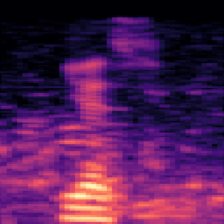

In [8]:
path = f'./{data_base_path}/train/known/yes/8134f43f_nohash_2.png'
get_image_resized(path)

## Models

CNN Model Resnet-18 not pretrained (random weights)

In [9]:
def get_resnet(n_classes: int):
    model_resnet = models.resnet18(pretrained=False)

    output_features = model_resnet.fc.in_features 
    ## We have 512 output features, we have to add to model a fully connected layer for our classification problem with only 10 target classes
    model_resnet.fc = nn.Linear(output_features, n_classes)
    model_resnet = model_resnet.to(device)
    return model_resnet

Custom CRNN

In [10]:
class CustomCRNN(nn.Module):

    def __init__(self, n_classes: int):
        super(CustomCRNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=24, out_channels=48, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(in_channels=48, out_channels=48, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        self.rnn = nn.LSTM(input_size=48 * 53 * 53, hidden_size=64)
        self.softmax = nn.Sequential(
            nn.Linear(64, n_classes),
            nn.Softmax(dim=1),
        )
        self.to(device)

    def forward(self, obs) -> torch.Tensor:
        out_conv = self.conv(obs)
        out_rnn = self.rnn(out_conv)[0]
        out_proba = self.softmax(out_rnn)
        return out_proba

Transformer VIT-base-16

In [11]:
vit_base = vit_b_16()

Transformer VIT-large-16

In [12]:
vit_large = vit_l_16()

## Train function

In [13]:
import os
import json
from datetime import datetime

In [14]:
def train(network: nn.Module, train_dataset: ImageFolder, valid_dataset: ImageFolder, batch_size: int,
          loss_fn, optimizer: torch.optim.Optimizer, max_epochs: int, advanced_augmentations=None, 
          save_name: str | None = None, verbosity_period=1) -> dict[str, list[float]]:
    """
    Based on: https://alirezasamar.com/blog/2023/03/fine-tuning-pre-trained-resnet-18-model-image-classification-pytorch/

    Returns:
        training statstics
    """
    train_loss_per_epoch: list[float] = []
    train_accuracy_per_epoch: list[float] = []
    valid_loss_per_epoch: list[float] = []
    valid_accuracy_per_epoch: list[float] = []

    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(max_epochs):
        epoch = epoch + 1

        # setup for training
        network.train()
        train_epoch_loss_sum = 0.0
        train_epoch_true_count = 0

        # training loop
        for images, true_labels in train_data_loader:
            # apply advanced augmentations (if specified)
            if advanced_augmentations is not None:
                images, true_labels = advanced_augmentations(images, true_labels)

            # move to the device (especially necessary when using cuda)
            images = images.to(device)
            true_labels = true_labels.to(device)

            # feed forward
            optimizer.zero_grad()
            pred_proba = network(images)

            loss = loss_fn(pred_proba, true_labels)
            # backpropagation and update weights
            loss.backward()
            optimizer.step()

            # update current epoch's stats
            train_epoch_loss_sum += loss.item() * images.size(0)
            # calculate accuracy but only if no advanced augmentations are used
            # this is because with advanced augmentations true_labels becomes
            # probabilites of each class
            if advanced_augmentations is None:
                pred_labels = torch.argmax(pred_proba, dim=1)
                train_epoch_true_count += torch.sum(pred_labels == true_labels.data)

        # calculate and update stats
        curr_train_loss = float(train_epoch_loss_sum / len(train_dataset))
        train_loss_per_epoch.append(curr_train_loss)
        if advanced_augmentations is None:
            curr_train_accuracy = float(train_epoch_true_count.double() / len(train_dataset))
            train_accuracy_per_epoch.append(curr_train_accuracy)

        # setup for validation
        network.eval()
        valid_epoch_loss_sum = 0.0
        valid_epoch_true_count = 0

        with torch.no_grad():
            # same as before but on validation data
            for images, true_labels in valid_data_loader:
                # move to device
                images = images.to(device)
                true_labels = true_labels.to(device)

                # make a prediction
                pred_proba = network(images)
                pred_labels = torch.argmax(pred_proba, dim=1)
                loss = loss_fn(pred_proba, true_labels)

                # update stats
                valid_epoch_loss_sum += loss.item() * images.size(0)
                valid_epoch_true_count += torch.sum(pred_labels == true_labels.data)

        # calculate and update stats
        curr_valid_loss = float(valid_epoch_loss_sum / len(val_dataset))
        curr_valid_acccuracy = float(valid_epoch_true_count.double() / len(val_dataset))
        valid_loss_per_epoch.append(curr_valid_loss)
        valid_accuracy_per_epoch.append(curr_valid_acccuracy)

        # Verbosity
        if  verbosity_period > 0 and epoch % verbosity_period == 0:
            train_acc_text = ''
            if advanced_augmentations is None:
                train_acc_text = f'Train accuracy: {curr_train_accuracy:.4f} | '
            print(f'Epoch {epoch} completed! | '
                  f'Train loss: {curr_train_loss:.4f} | '
                  f'{train_acc_text}'
                  f'Validation loss: {curr_valid_loss:.4f} | '
                  f'Validation accuracy: {curr_valid_acccuracy:.4f}')

    stats = {
        'train_loss': train_loss_per_epoch,
        'train_accuracy': train_accuracy_per_epoch,
        'valid_loss': valid_loss_per_epoch,
        'valid_accuracy': valid_accuracy_per_epoch,
    }

    # save network weights and stats at the end
    if save_name is not None:
        # prepare save dir
        datetime_id = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
        save_dir = os.path.join('.', 'saved', f'{save_name}_{datetime_id}')
        os.makedirs(save_dir, exist_ok=True)
        # save network weights
        model_path = os.path.join(save_dir, f'{save_name}.pth')
        torch.save(network.state_dict(), model_path)
        # save training stats
        stats_path = os.path.join(save_dir, f'{save_name}.json')
        with open(stats_path, 'w') as file:
            json.dump(stats, file)
    
    return stats

In [15]:
def load_weights(network_fresh: nn.Module, path: str) -> None:
    """Loads saved weights to the given network"""
    network_fresh.load_state_dict(torch.load(path, map_location=torch.device(device)))
    network_fresh.eval()

In [16]:
def load_stats(path: str) -> dict[str, list[float]]:
    with open(path) as file:
        stats = json.load(file)
    return stats

# Train models

### Train Resnet-18 not pretrained

In [17]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

model_resnet = get_resnet(10)

stats_resnet = train(
    model_resnet, train_dataset, val_dataset, 
    batch_size=128, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9), 
    max_epochs=5,
    save_name='architectures_resnet',
)

Epoch 1 completed! | Train loss: 1.8787 | Train accuracy: 0.5000 | Validation loss: 1.0504 | Validation accuracy: 0.0000
Epoch 2 completed! | Train loss: 1.5716 | Train accuracy: 1.0000 | Validation loss: 0.0006 | Validation accuracy: 1.0000
Epoch 3 completed! | Train loss: 1.1182 | Train accuracy: 1.0000 | Validation loss: 0.0000 | Validation accuracy: 1.0000
Epoch 4 completed! | Train loss: 0.6541 | Train accuracy: 1.0000 | Validation loss: 0.0000 | Validation accuracy: 1.0000
Epoch 5 completed! | Train loss: 0.3222 | Train accuracy: 1.0000 | Validation loss: 0.0000 | Validation accuracy: 1.0000


### Train vit base

In [18]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

stats_vit_base = train(
    vit_base, train_dataset, val_dataset, 
    batch_size=128, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.SGD(vit_base.parameters(), lr=0.001, momentum=0.9), 
    max_epochs=5,
    save_name='architectures_vit_base',
)

Epoch 1 completed! | Train loss: 6.9078 | Train accuracy: 1.0000 | Validation loss: 6.1445 | Validation accuracy: 1.0000
Epoch 2 completed! | Train loss: 6.1411 | Train accuracy: 1.0000 | Validation loss: 4.7000 | Validation accuracy: 1.0000
Epoch 3 completed! | Train loss: 4.6902 | Train accuracy: 1.0000 | Validation loss: 2.6961 | Validation accuracy: 1.0000
Epoch 4 completed! | Train loss: 2.6783 | Train accuracy: 1.0000 | Validation loss: 0.7211 | Validation accuracy: 1.0000
Epoch 5 completed! | Train loss: 0.7056 | Train accuracy: 1.0000 | Validation loss: 0.0685 | Validation accuracy: 1.0000


### Custom CRNN

In [19]:
torch.manual_seed(28)
torch.cuda.manual_seed(28)

model_crnn = CustomCRNN(2)

stats_crnn = train(
    model_crnn, train_dataset, val_dataset, 
    batch_size=128, 
    loss_fn=nn.CrossEntropyLoss(), 
    optimizer=optim.SGD(model_crnn.parameters(), lr=0.001, momentum=0.9), 
    max_epochs=5,
    save_name='architectures_crnn'
)

Epoch 1 completed! | Train loss: 0.6030 | Train accuracy: 1.0000 | Validation loss: 0.6626 | Validation accuracy: 1.0000
Epoch 2 completed! | Train loss: 0.5839 | Train accuracy: 1.0000 | Validation loss: 0.6804 | Validation accuracy: 1.0000
Epoch 3 completed! | Train loss: 0.5818 | Train accuracy: 1.0000 | Validation loss: 0.6483 | Validation accuracy: 1.0000
Epoch 4 completed! | Train loss: 0.5622 | Train accuracy: 1.0000 | Validation loss: 0.6131 | Validation accuracy: 1.0000
Epoch 5 completed! | Train loss: 0.5461 | Train accuracy: 1.0000 | Validation loss: 0.5906 | Validation accuracy: 1.0000


### Hyperparameters